# Challenge SD207 - 2017
*<p>Author: Pengfei MI, Rui SONG</p>*
*<p>Date: 06/06/2017</p>*

In [1]:
import numpy as np
import scipy as sp
from scipy.stats import mode
import pandas as pd
import matplotlib.pyplot as plt
from time import time
import random

import librosa
import librosa.display

from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report

In [2]:
# Define some usefull functions
def load_sound_files(file_paths):
    raw_sounds = []
    for fp in file_paths:
        X, sr = librosa.load(fp, sr=None)
        raw_sounds.append(X)
    return raw_sounds

def plot_waves(sound_names,raw_sounds):
    i = 1
    fig = plt.figure(figsize=(20, 5*len(sound_names)))
    for n, f in zip(sound_names, raw_sounds):
        plt.subplot(len(sound_names), 1, i)
        librosa.display.waveplot(np.array(f), sr=16000)
        plt.title(str(n))
        i += 1
    plt.suptitle("Figure 1: Waveplot")
    plt.show()
    
def plot_specgram(sound_names,raw_sounds):
    i = 1
    fig = plt.figure(figsize=(20, 5*len(sound_names)))
    for n, f in zip(sound_names, raw_sounds):
        plt.subplot(len(sound_names), 1, i)
        plt.specgram(np.array(f), Fs=16000)
        plt.title(str(n))
        i += 1
    plt.suptitle("Figure 2: Spectrogram")
    plt.show()

def plot_log_power_specgram(sound_names,raw_sounds):
    i = 1
    fig = plt.figure(figsize=(20, 5*len(sound_names)))
    for n, f in zip(sound_names, raw_sounds):
        plt.subplot(len(sound_names), 1, i)
        D = librosa.logamplitude(np.abs(librosa.stft(f))**2, ref_power=np.max)
        librosa.display.specshow(D,x_axis='time' ,y_axis='log')
        plt.title(str(n))
        i += 1
    plt.suptitle("Figure 3: Log power spectrogram")
    plt.show()

In [3]:
# Read data and preprocessing
FILEROOT = './'

files_train = pd.read_csv('train.txt', sep='\s+', header=None)[0].values
labels_train = pd.factorize(pd.read_csv('train.txt', sep='\s+', header=None)[1])[0]
files_val = pd.read_csv('dev.txt', sep='\s+', header=None)[0].values
labels_val = pd.factorize(pd.read_csv('dev.txt', sep='\s+', header=None)[1])[0]
files_test = pd.read_csv('test_files.txt', header=None)[0].values

print "Training set size: %d" % len(files_train)
print "Validation set size: %d" % len(files_val)
print "Test set size: %d" % len(files_test)

Training set size: 582
Validation set size: 290
Test set size: 298


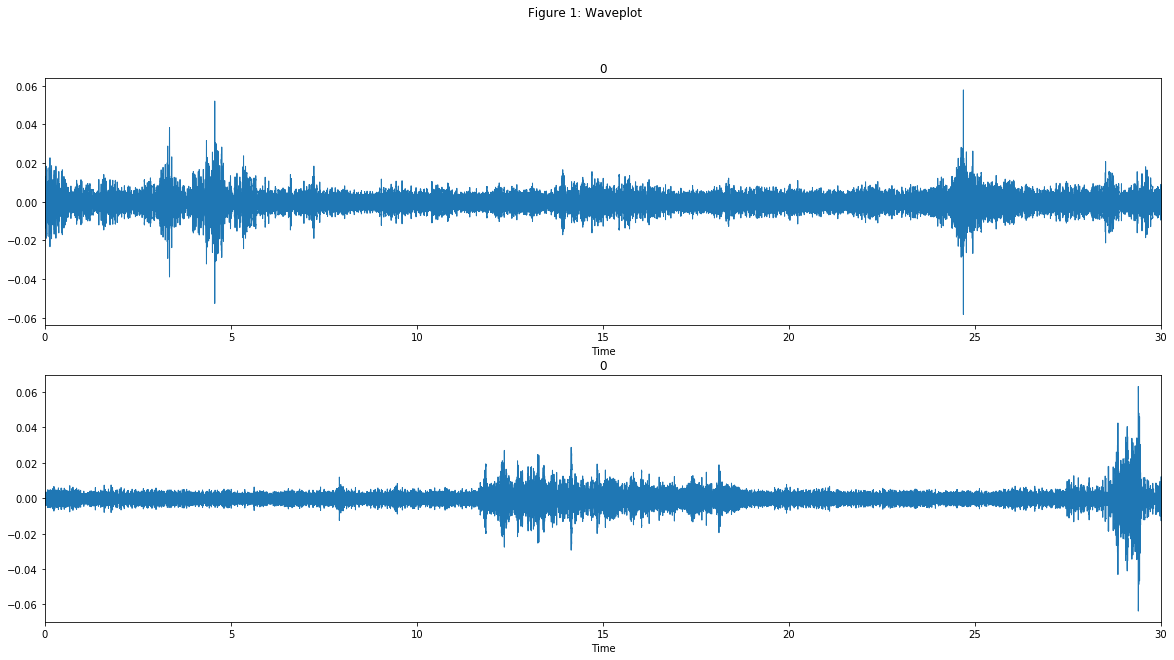

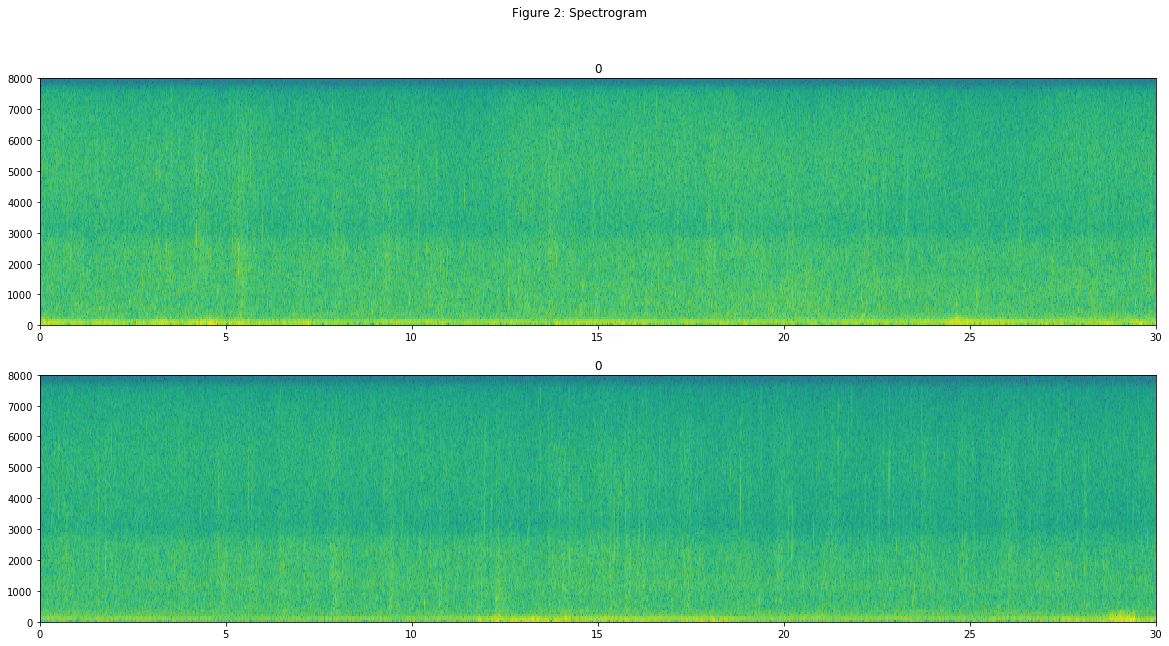

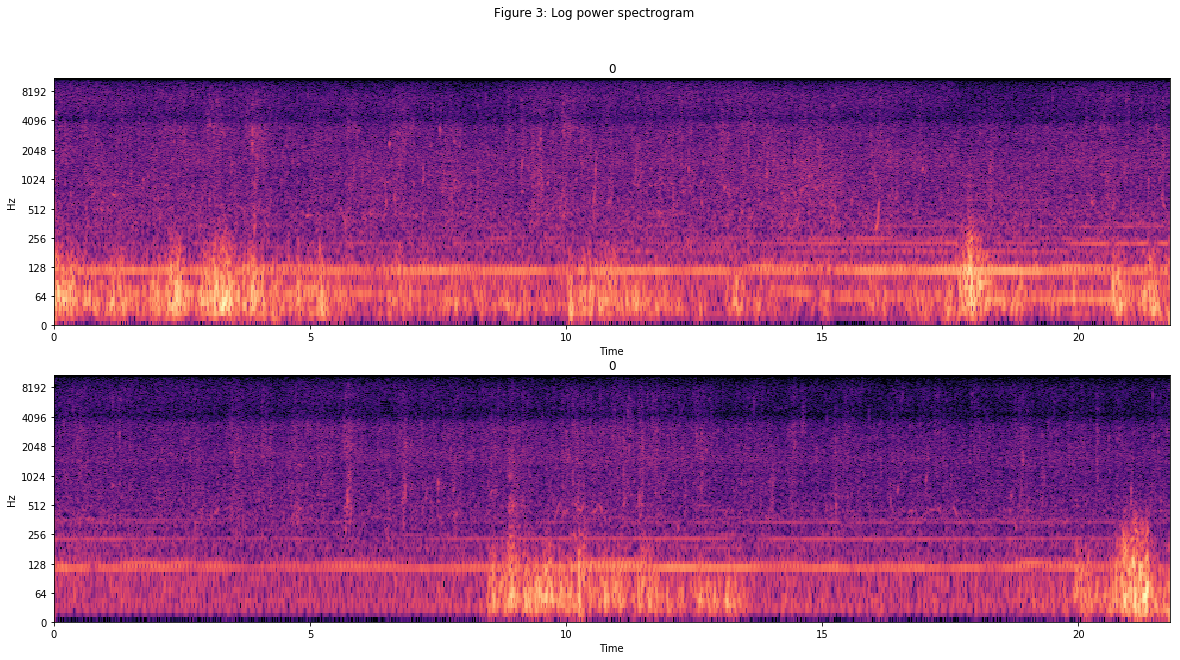

In [4]:
raw_sounds = load_sound_files(files_train[:2])

plot_waves(labels_train[:2], raw_sounds)
plot_specgram(labels_train[:2],raw_sounds)
plot_log_power_specgram(labels_train[:2],raw_sounds)

In [5]:
# Feature extraction
n_mfcc = 40
def extract_feature(file_name): # Late fusion
    X, sample_rate = librosa.load(file_name, sr=None)
    mfccs = librosa.feature.mfcc(y=X, sr=sample_rate, n_fft=1024, hop_length=1024, n_mfcc=n_mfcc).T
    return mfccs

def parse_audio_files(file_names, file_labels):
    features, labels = np.empty((0,n_mfcc)), np.empty(0)
    for fn, fl in zip(file_names, file_labels):
        try:
            mfccs = extract_feature(fn)
        except Exception as e:
            print "Error encountered while parsing file: ", fn
            continue
        features = np.vstack([features, mfccs])
        labels = np.append(labels, fl*np.ones(mfccs.shape[0]))
    return np.array(features), np.array(labels, dtype = np.int)

In [6]:
t0 = time()
X_train, y_train = parse_audio_files(files_train, labels_train)
print X_train.shape, y_train.shape
print "Done in %0.3fs." % (time()-t0)

(272958, 40) (272958,)
Done in 32.768s.


In [ ]:
def predict(clf, X_test):
    y_pred = np.empty(0)
    for x in X_test:
        x_mfccs = extract_feature(x)
        y_predicts = clf.predict(x_mfccs)
        y_pred = np.append(y_pred, mode(y_predicts).mode[0])
    return np.array(y_pred, dtype = np.int)

In [ ]:
# Train classifier
random.seed(42)
t0 = time()

params = {'hidden_layer_sizes': ((40, 40), (40, 20, 40), (64, 64, 64)),
          'alpha': np.logspace(-6, 0, 20)}

clf = GridSearchCV(MLPClassifier(), params, cv=5, n_jobs=-1)
clf.fit(X_train, y_train)

print("Best parameters set found on training set:")
print(clf.best_params_)
print '\n'

print "Done in %0.3fs." % (time()-t0)

Process PoolWorker-23:
Process PoolWorker-21:
Process PoolWorker-20:
Process PoolWorker-22:
Process PoolWorker-18:
Process PoolWorker-24:
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Process PoolWorker-19:
Process PoolWorker-17:
Traceback (most recent call last):
Traceback (most recent call last):
  File "/Applications/anaconda2/lib/python2.7/multiprocessing/process.py", line 258, in _bootstrap
  File "/Applications/anaconda2/lib/python2.7/multiprocessing/process.py", line 258, in _bootstrap
  File "/Applications/anaconda2/lib/python2.7/multiprocessing/process.py", line 258, in _bootstrap
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
  File "/Applications/anaconda2/lib/python2.7/multiprocessing/process.py", line 258, in _bootstrap
  File "/Applications/anaconda2/lib/python2.7/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
    self.run()
  File "/Ap

In [ ]:
y_val_pred = predict(clf, files_val)
print "Score on validation test: %f" % np.mean(y_val_pred == labels_val)
print y_val_pred

In [ ]:
y_test_pred = predict(clf, files_test)
np.savetxt('y_test_pred_mfcc.txt', y_test_pred, fmt='%d')
print y_test_pred